
Predicting Customer Churn in Telco

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML).

This notebook walks you through these steps:

    Build a model to predict customer churn
    Test the accuracy of the model
    Save the model in the ML repository
    Display your models in the ML repository


Use Case:

The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. The diagram below depicts the CRISP-DM methodology:


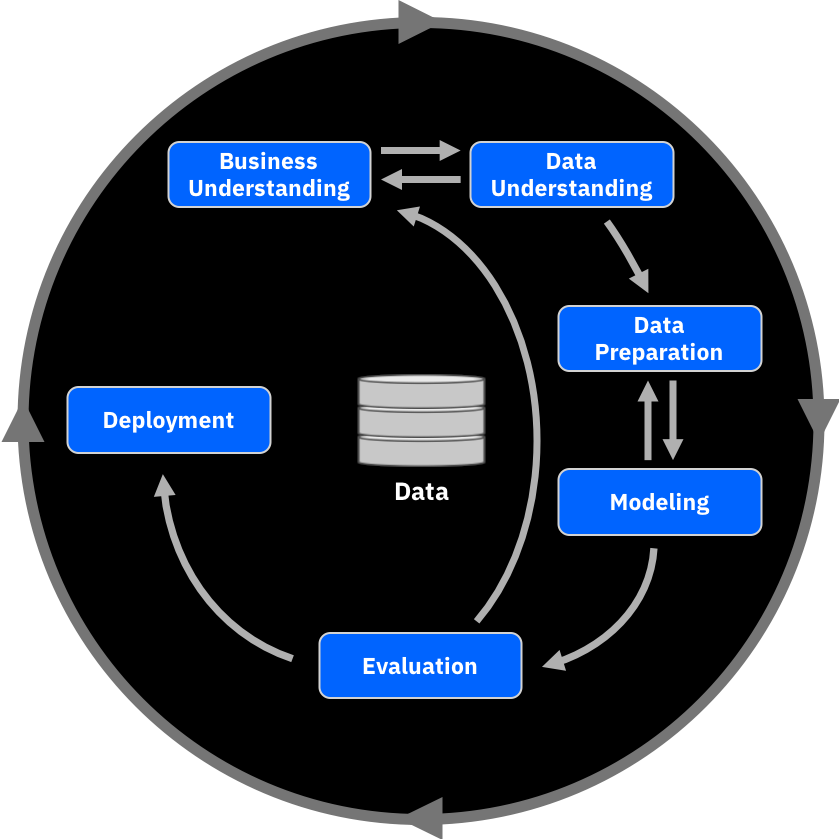


The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables).

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set.

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.

The diagram below represents how the CRISP-DM methodology maps to the Watson Studio and Watson Knowledge Catalog. This notebook will highlight the how the cells support the methodology via description on the top of the cell.


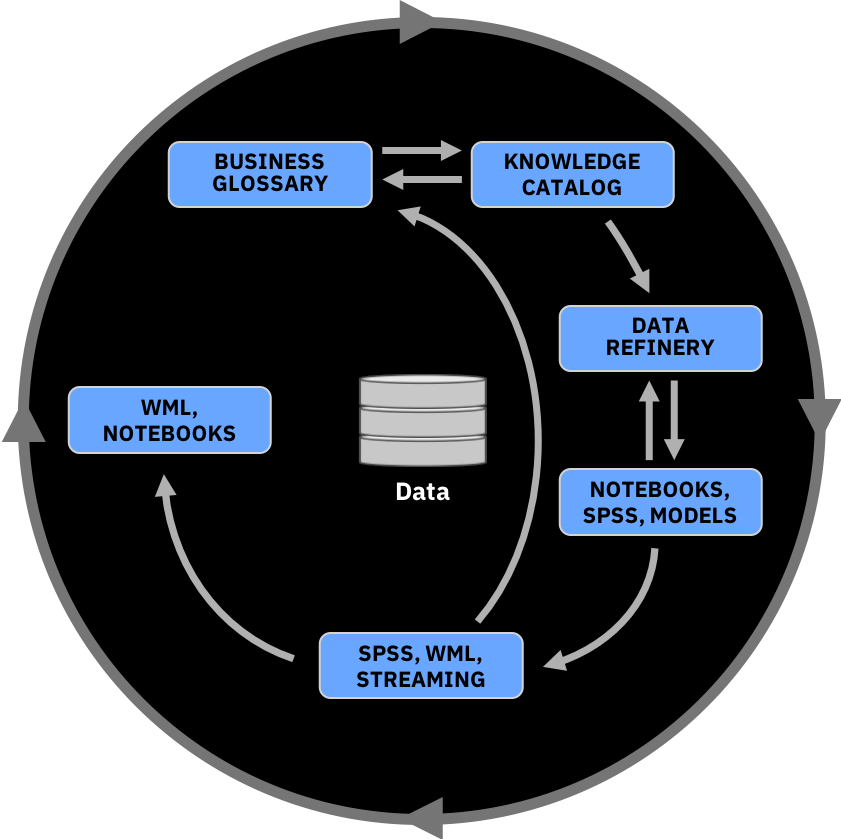


Working with Notebooks:

If you are new to Notebooks, here's a quick overview of how to work in this environment.

    To run the notebook, it must be in the Edit mode. If you don't see the menu in the notebook, then it's not in the edit mode. Click on the pencil icon.
    The notebook has 2 types of cells - markdown (text) and code.
    Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one 
      cell at a time because we need to make code changes to some of the cells.
    To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have 
      printable output.
    Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them.



# Environment Preparation

In [1]:
## ------------------------------------------------------
## This cell must be run when the noyeboo is started.
## Once this cell is run please restart the kernal for the libaries to become avaailable and effective
## Then continue in the Data Preparation cell below
## ------------------------------------------------------

# install pixiedust libraries for visualization example
!pip install pixiedust --upgrade
# install WML client libraries
!pip install watson-machine-learning-client --upgrade

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191015145415-0000
KERNEL_ID = bdbcfb17-231d-44ca-8e3a-f27a8cd54c98
    100% |################################| 204kB 2.7MB/s eta 0:00:01
    100% |################################| 798kB 1.8MB/s eta 0:00:01
    100% |################################| 5.8MB 1.8MB/s eta 0:00:01
    100% |################################| 92kB 3.1MB/s eta 0:00:01
    100% |################################| 61kB 2.1MB/s eta 0:00:01
    100% |################################| 583kB 3.4MB/s eta 0:00:01
    100% |################################| 163kB 4.4MB/s eta 0:00:01
    100% |################################| 133kB 4.0MB/s eta 0:00:01
    100% |################################| 143kB 4.3MB/s eta 0:00:01
    100% |################################| 61kB 2.3MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/25/fa/a5/09c1e8f4c91b34c5f7f4ac6e41be81dd0667030a2372546a8d
  Stored in directory: /hom

    100% |################################| 20.4MB 642kB/s eta 0:00:01
    100% |################################| 512kB 3.8MB/s eta 0:00:01
    100% |################################| 757kB 4.1MB/s eta 0:00:01
    100% |################################| 143kB 4.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/14/2c/cd551d81dbe15200be1cf41cd03869a46fe7226e7450af7a6545bfc474c9/idna-2.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
    100% |################################| 552kB 3.7MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/6f/90/cc/78216d4fb08b6736364c4c68da6662feafc1094c4dd17f47c7
  Stored in directory: /home/spark/shared/.cache/pip/wheels/e1/41/5e/e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
  Stored in directory: /home/spark/shared/.cache/pip/wheels/fc/44/91/3ac9ece0b3759e16ec32ff19e7ea09a

# Data Preparation

In [2]:
# This step represents part of the Data Preparation process. Joining of the files will be done in this Notebook
#
# Add connection logic to load data from the Catalog after the comments section.
#
# Add each data file using a Spark DataFrame:
#     1) Select the "1001" Data menu icon on the right to display files from the catalog.
#     2) Select "Insert to Code" under the customer.csv in the list on the left  
#     3) Select the "Insert SparkSession DataFrame" menu option to add the file to this notebook
#     4) Select "Insert to Code" under the churn.csv in the list on the left  
#     5) Select the "Insert SparkSession DataFrame" menu option to add the file to this notebook
#
# Next we will need to customize that code a little
#     In each of the spark.read sections, the following code must be added (under the existing .option code):
#     1) .option('inferSchema', 'true')\
#     2) All occurences of df_data_1 (customer file) must be changed to customer
#     3) All occurances of df_data_2 (churn file) must be changed to customer_churn
#
# The assignment of these variables will allow the subsequent steps to run properly. The system provides
#   a default naming convention as a starting point. Good coding practices dictate that these types of
#   names should be changed to make your code easier to follow...
#
# ------------------------------------------------------------------------------------------------


In [3]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-5a988285-b05d-4148-afb9-19cbd594edb6',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'kUkuG6QrEdOHy3MRJBp1CS_f0FuIrbjfK6mYDjAh-c6p'
}

configuration_name = 'os_cba83a820ee941cd921cc2bbfefd15eb_configs'

In [4]:
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
customer = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(cos.url('customer.csv', 'taller-donotdelete-pr-oig7dhr92xtgem'))

customer_churn = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(cos.url('churn.csv', 'taller-donotdelete-pr-oig7dhr92xtgem'))

In [5]:
customer.take(5)
customer_churn.take(5)

[Row(ID=1, CHURN='T'),
 Row(ID=6, CHURN='F'),
 Row(ID=8, CHURN='F'),
 Row(ID=11, CHURN='F'),
 Row(ID=14, CHURN='F')]

In [6]:
# The following cells are part of the Data Understanding & Data Preparation processes. They provide details about
#   the contents of the various input files and provide some visualization of the information used to create the
#   customer churn model.
#
# get the record count for the customer input file
customer.count()

2066

In [7]:
# get the record count for the customer churn input file
customer_churn.count()

2066

In [8]:
# merge together the customer and churn files
data=customer.join(customer_churn,customer['ID']==customer_churn['ID']).select(customer['*'],customer_churn['CHURN'])

In [9]:
# rename some columns as example of output preparation
data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
data.toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1,38000.00,N,24.393333,23.56,0.0,206.08,0,CC,Budget,Intnl_discount,229.64,3,T
1,6,M,M,2,29616.00,N,49.426667,29.78,0.0,45.50,0,CH,FreeLocal,Standard,75.29,2,F
2,8,M,M,0,19732.80,N,50.673333,24.81,0.0,22.44,0,CC,FreeLocal,Standard,47.25,3,F
3,11,M,S,2,96.33,N,56.473333,26.13,0.0,32.88,1,CC,Budget,Standard,59.01,1,F
4,14,F,M,2,52004.80,N,25.140000,5.03,0.0,23.11,0,CH,Budget,Intnl_discount,28.14,1,F


In [10]:
# perform visualization of the data

from pixiedust.display import *
display(data)

ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
17,M,M,2,53010.8,N,18.84,12.45,0.0,46.42,4,CC,FreeLocal,Standard,58.87,1,F
104,M,S,2,43634.5,N,21.78,29.44,9.42,104.64,0,CC,Budget,Standard,143.5,1,T
111,M,S,0,74460.7,Y,55.34,25.53,0.99,179.93,0,CC,FreeLocal,Standard,206.46,2,T
139,F,S,2,6440.46,Y,52.646667,22.66,0.0,27.2,0,CH,Budget,Standard,49.86,1,F
169,F,S,0,93322.1,Y,40.313333,29.92,0.0,8.79,0,CH,Budget,Intnl_discount,38.72,1,T
215,M,M,1,69680.9,N,15.846667,7.67,0.0,32.12,0,CC,FreeLocal,Intnl_discount,39.8,2,F
228,F,M,0,14932.5,N,52.0,4.91,0.0,6.5,0,CC,Budget,Intnl_discount,11.42,1,F
233,F,M,1,66000.0,Y,63.353333,6.08,0.0,30.95,0,Auto,FreeLocal,Intnl_discount,37.04,2,F
306,F,S,0,43382.3,N,16.073333,29.67,8.76,99.94,0,CH,FreeLocal,Standard,138.37,2,T
326,M,M,0,100020.0,Y,52.266667,29.55,0.0,62.81,0,CH,Budget,Standard,92.37,4,T


## Modeling

In [11]:
# The following cells are part of the Modeling process. They prepare the information for use with the Randon
#   Forester algorithm and build, train, and identify the accuracy of the customer churn model.
#
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline, Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import json
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)

# Apply OneHotEncoder so categorical features aren't given numeric importance
OH1 = OneHotEncoder(inputCol="GenderEncoded", outputCol="GenderEncoded"+"classVec")
OH2 = OneHotEncoder(inputCol="StatusEncoded", outputCol="StatusEncoded"+"classVec")
OH3 = OneHotEncoder(inputCol="CarOwnerEncoded", outputCol="CarOwnerEncoded"+"classVec")
OH4 = OneHotEncoder(inputCol="PaymethodEncoded", outputCol="PaymethodEncoded"+"classVec")
OH5 = OneHotEncoder(inputCol="LocalBilltypeEncoded", outputCol="LocalBilltypeEncoded"+"classVec")
OH6 = OneHotEncoder(inputCol="LongDistanceBilltypeEncoded", outputCol="LongDistanceBilltypeEncoded"+"classVec")


# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncodedclassVec", "StatusEncodedclassVec", "CarOwnerEncodedclassVec", "PaymethodEncodedclassVec", "LocalBilltypeEncodedclassVec", \
                                       "LongDistanceBilltypeEncodedclassVec", "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                      "Dropped","Usage","RatePlan"], outputCol="features")

## Evaluation

In [12]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, OH1, OH2, OH3, OH4, OH5, OH6, assembler, rf, labelConverter])

In [13]:
# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: int, EstIncome: double, CarOwner: string, Age: double, LongDistance: double, International: double, Local: double, Dropped: int, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: int, CHURN: string]

In [14]:
# Build models
model = pipeline.fit(train)

In [15]:
# display prediction results
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURN,label,predictedLabel,prediction,probability
0,14,F,0.0,F,0.0,"[0.9591697236841771, 0.040830276315822985]"
1,18,F,0.0,F,0.0,"[0.6690006139722653, 0.3309993860277347]"
2,21,F,0.0,F,0.0,"[0.7041394547687685, 0.2958605452312315]"
3,22,F,0.0,F,0.0,"[0.7878434977118512, 0.21215650228814872]"
4,29,T,1.0,T,1.0,"[0.36580590989613115, 0.6341940901038688]"
5,40,T,1.0,T,1.0,"[0.2517948861319216, 0.7482051138680785]"


In [16]:
# print accuracy prediction
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Model
predictions = model.transform(test)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

print("Accuracy = %g" % accuracy)

Accuracy = 0.913753


## Deployment

The following cells begin the Deployment process. This initial step publishes the model to the Machine Learning
library. It does not deploy the model for use in the IBM Cloud environment. That process is performed in a
deployment notebook that is done later. The 2 functions have been seperated to more accurately
demonstrate how the CRISP-DM process would be executed in a real world scenario.

In [17]:
# import the installed WML client from above
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Reason: 'NoneType' object has no attribute 'groups'
Reason: 'NoneType' object has no attribute 'groups'
Reason: 'NoneType' object has no attribute 'groups'


In [18]:
# taller-wml-01

wml_credentials= {
  "apikey": "wQtynZqalHaH5bbfIiMsBnyeJaQNif1BYaxfaW9Ixnig",
  "iam_apikey_description": "Auto-generated for key 92def0ed-42f3-4823-aa88-291e19f75f26",
  "iam_apikey_name": "taller",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/4d1d4ceca03edb232a591b11995dbd1f::serviceid:ServiceId-13e8554b-17c0-47f7-a79a-69cdccc2efb8",
  "instance_id": "466855e5-8ca6-4235-bac7-1f57815409ce",
  "password": "0dca841d-6d9b-410c-9dac-d5bfd56203ff",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "92def0ed-42f3-4823-aa88-291e19f75f26"
}

In [19]:
# create API client
client = WatsonMachineLearningAPIClient(wml_credentials)

In [20]:
# display instance details of the ML library
instance_details = client.service_instance.get_details()

print(json.dumps(instance_details, indent=2))

{
  "metadata": {
    "guid": "466855e5-8ca6-4235-bac7-1f57815409ce",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/466855e5-8ca6-4235-bac7-1f57815409ce",
    "created_at": "2019-07-04T07:19:37.592Z",
    "modified_at": "2019-10-15T14:49:06.673Z"
  },
  "entity": {
    "source": "Bluemix",
    "published_models": {
      "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/466855e5-8ca6-4235-bac7-1f57815409ce/published_models"
    },
    "usage": {
      "expiration_date": "2019-11-01T00:00:00.000Z",
      "computation_time": {
        "limit": 180000,
        "current": 0
      },
      "gpu_count_k80": {
        "limit": 8,
        "current": 0
      },
      "model_count": {
        "limit": 200,
        "current": 7
      },
      "gpu_count_p100": {
        "limit": 0,
        "current": 0
      },
      "prediction_count": {
        "limit": 5000,
        "current": 3
      },
      "capacity_units": {
        "limit": 180000000,
        "current": 499287
 

In [25]:
# publish the model to the repository (not deployed yet - deployment step to follow)
# modify the information below with your information...
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "Ramiro Rego", 
               client.repository.ModelMetaNames.NAME: "Customer Churn From Notebook - RRA"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train)

In [26]:
# display the details of the model that was just published
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "metadata": {
    "guid": "cd8f26d8-8d5b-44db-ae1a-c09263ecd58f",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/466855e5-8ca6-4235-bac7-1f57815409ce/published_models/cd8f26d8-8d5b-44db-ae1a-c09263ecd58f",
    "created_at": "2019-10-15T15:00:12.769Z",
    "modified_at": "2019-10-15T15:00:12.988Z"
  },
  "entity": {
    "runtime_environment": "spark-2.3",
    "learning_configuration_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/466855e5-8ca6-4235-bac7-1f57815409ce/published_models/cd8f26d8-8d5b-44db-ae1a-c09263ecd58f/learning_configuration",
    "author": {
      "name": "Ramiro Rego"
    },
    "name": "Customer Churn From Notebook - RRA",
    "label_col": "CHURN",
    "learning_iterations_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/466855e5-8ca6-4235-bac7-1f57815409ce/published_models/cd8f26d8-8d5b-44db-ae1a-c09263ecd58f/learning_iterations",
    "training_data_schema": {
      "fields": [
        {
          "metadata": {},
          "nam

In [27]:
# list all of your models to be sure it has been published to the ML repository (not deployed yet)
client.repository.list_models()

------------------------------------  --------------------------------------------  ------------------------  -----------------
GUID                                  NAME                                          CREATED                   FRAMEWORK
cd8f26d8-8d5b-44db-ae1a-c09263ecd58f  Customer Churn From Notebook - RRA            2019-10-15T15:00:12.769Z  mllib-2.3
2bcb9b5b-7e17-4e67-808f-2d8e9af93343  Customer Churn From Notebook - your_initials  2019-10-15T14:59:50.037Z  mllib-2.3
dc2fcdc4-ffbe-490d-9467-1217d45bdf36  Decision Tree Classifier                      2019-10-15T13:28:24.839Z  wml-1.2
d92e53e9-7d37-4110-8bdc-c7a66bba94fe  Table                                         2019-10-15T12:58:09.708Z  spss-modeler-18.1
994c09a8-1369-4f71-9fde-874c3f50c076  Automatic car price model                     2019-07-04T09:56:34.843Z  wml-1.2
8c9c0afe-44d5-49ff-bc92-3f76f266538a  SPSS Car Price Regression model               2019-07-04T09:47:34.748Z  spss-modeler-18.1
a1a16f68-abc6-48fd-a

In [30]:
# test the loaded model to make sure it is published & loaded properly - show top 3 rows for output...
loaded_model = client.repository.load(published_model_uid)
test_predictions = loaded_model.transform(test)
test_predictions.select('probability', 'predictedLabel').show(n=3, truncate=False)

WMLClientError: Loading model with artifact_uid: 'cd8f26d8-8d5b-44db-ae1a-c09263ecd58f' failed.
Reason: 'NoneType' object has no attribute 'groups'